## BC Raw Log Exports

#### Mark Gibbs, Gibbs Consulting

Data taken from [BC Government- Forestry Trade](https://www2.gov.bc.ca/gov/content/data/statistics/business-industry-trade/industry/forestry) and [OECD - CPI](https://data.oecd.org/price/inflation-cpi.htm) websites.

This notebook is a high-level study of the history of the values of raw log exports from BC, as reported by the BC Provincial Government.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

The dataset is a locally cached copy in CSV format.

In [2]:
raw_data = pd.read_csv("raw_data/BCLogExports_MinFor_180112.csv",header=1,thousands=",").dropna(how='any')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7735 entries, 0 to 7734
Data columns (total 6 columns):
Year                   7735 non-null object
Month                  7735 non-null object
Commodity              7735 non-null object
Destination Country    7735 non-null object
Value - Cdn $          7735 non-null float64
Quantity - m3          7735 non-null float64
dtypes: float64(2), object(4)
memory usage: 423.0+ KB


For convenience, it is worth providing cleaner names for the columns, and mapping the date part of the input to numeric values.

In [3]:
raw_data.columns = ["Year","Month","Commodity",'Destination','Value','Quantity']
dfMonths = pd.DataFrame({'Month':['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],'MonthIndex':range(12)})
data = pd.merge(raw_data,dfMonths,on="Month")
data['Year'] = data['Year'].apply(int)

Now, annualise the data. There are a number of ways to achieve this, depending on what sort of missing data needs to be dealth with. Notably, this dataset does not contain entries for all of 2017. The approach taken here is to work out the average for each month in a given year, and multiply by 12. This is equivalent to allocating to each missing month a value equal to the average of the known months.

In [4]:
aggregated = data.groupby(['Year','Destination'])['Value','Quantity'].mean() * 12
totals = aggregated.reset_index().groupby(['Year']).sum()

Text(0.5,0.98,'Total annual log export value, CAD Millions')

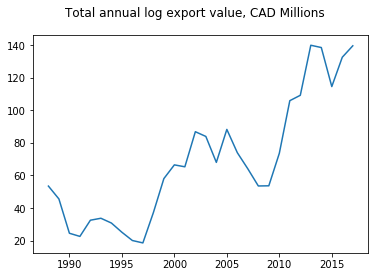

In [5]:
plt.plot(totals['Value']/1000000)
plt.suptitle("Total annual log export value, CAD Millions",fontsize=12)

In [6]:
annual_pivot = aggregated.reset_index().pivot(index="Year",columns="Destination",values="Value").fillna(0)
annual_pivot.columns

Index(['Albania', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Belgium', 'Bermuda', 'Czech Republic', 'Denmark',
       'Finland', 'France', 'French Polynesia', 'Germany', 'Greece',
       'Guatemala', 'Hong Kong', 'Iceland', 'India', 'Indonesia', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Laos',
       'Latvia', 'Lebanon', 'Mainland China', 'Malaysia', 'Mexico',
       'Netherlands', 'New Zealand', 'North Korea', 'Pakistan', 'Peru',
       'Philippines', 'Russia', 'Saudi Arabia', 'Singapore', 'South Africa',
       'South Korea', 'Spain', 'St Pierre-Miquelin', 'Sweden', 'Switzerland',
       'Taiwan', 'Thailand', 'Turkey', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Vietnam'],
      dtype='object', name='Destination')

In [7]:
total_value = totals['Value']

Define a function for determining the relative contribution of a specific country.

In [8]:
def country_stats(annual_pivot,country,totalValue):
    cValue = annual_pivot[country]
    fraction = cValue / total_value
    return fraction

Highlight three large export destinations by picking them out for individual treatment.

In [9]:
per_country = {}
for c in ['Japan','United States','Mainland China']:
    per_country[c] = country_stats(annual_pivot,c,total_value)

In [10]:
dfFracs = pd.DataFrame(per_country)
dfFracs['Rest of World'] = 1 - dfFracs.apply(np.sum,axis=1)

Text(0.5,0.98,'Export destination as fraction of total export value')

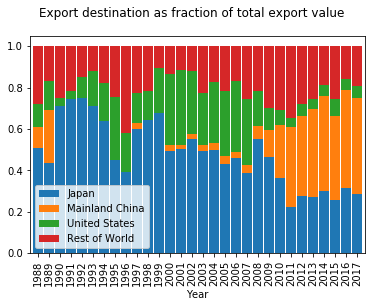

In [11]:
dfFracs.plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination as fraction of total export value", fontsize=12)

In [12]:
dfValues = pd.DataFrame(per_country)
for c in per_country.keys():
    dfValues[c] = dfValues[c] * total_value
dfValues['Rest of World'] = total_value - dfValues.apply(np.sum,axis=1)
dfValues /= 1000000

The previous plot demonstrated the relative importance of the United States in the first decade of this century, and the emergence of China since then. It is instructive to look at the absolute value of trade with these destinations.

Text(0.5,0.98,'Export destination export values, CAD Millions')

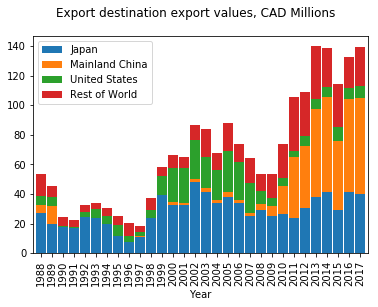

In [13]:
dfValues.plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination export values, CAD Millions", fontsize=12)

## Inflation adjustment

The previous chart showed the value of the log export trade using simple currency values. Using OECD CPI data it is possible to take inflation into account.

Again, a locally cached copy of the data (in CSV format) is used.

In [14]:
raw_cpi = pd.read_csv("raw_data/oecd_inflation_20180117.csv",header=0,thousands=",")#.dropna(how='any')
raw_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18039 entries, 0 to 18038
Data columns (total 8 columns):
LOCATION      18039 non-null object
INDICATOR     18039 non-null object
SUBJECT       18039 non-null object
MEASURE       18039 non-null object
FREQUENCY     18039 non-null object
TIME          18039 non-null object
Value         18039 non-null float64
Flag Codes    0 non-null float64
dtypes: float64(2), object(6)
memory usage: 1.1+ MB


As well as converting the TIME argument to more useful Year and Month columns, the per-month annualised CPI rates should be converted into per-month inflation indexation factors. The product of these is then the annualised indexation factor.

In [15]:
raw_cpi['Year'] = raw_cpi['TIME'].apply(lambda x:x[:4]).apply(int)
raw_cpi['Month'] = raw_cpi['TIME'].apply(lambda x:x[5:]).apply(int)
raw_cpi['PerMonthFactor'] = 1+(raw_cpi['Value'] * (0.01/12))
cpi_indexation = raw_cpi.groupby(['LOCATION','Year'])['PerMonthFactor'].prod().reset_index()

In [16]:
annual_indexation_factors = cpi_indexation.pivot(index="Year",columns="LOCATION",values="PerMonthFactor")
annual_index = annual_indexation_factors.apply(np.cumprod,axis=0)

The indexation factor is a conversion factor relative to the end of each
year. By picking 2017 as the base year, the lack of a full year's CPI data is not an issue.

In [17]:
canada_rpi = annual_index['CAN']
# Rebase to 2017 values; this conveniently skips over the partial year nature of 2017
canada_rpi /= canada_rpi[2017]

The canada_rpi data can now be used to scale the other values to convert them to end-2017 equivalents.

In [18]:
dfInfAdjValues = pd.DataFrame(per_country)
for c in per_country.keys():
    dfInfAdjValues[c] = dfInfAdjValues[c] * total_value / canada_rpi
dfInfAdjValues['Rest of World'] = total_value/canada_rpi - dfValues.apply(np.sum,axis=1)
dfInfAdjValues /=1000000

Text(0.5,0.98,'Export destination export values, inflation rebased to 2017 CAD Millions')

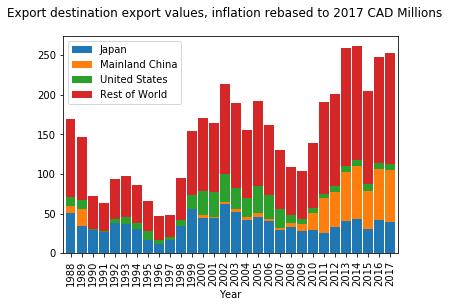

In [19]:
dfInfAdjValues.plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination export values, inflation rebased to 2017 CAD Millions", fontsize=12)

Text(0.5,0.98,'Japanese export values, raw and inflation rebased to 2017 CAD Millions')

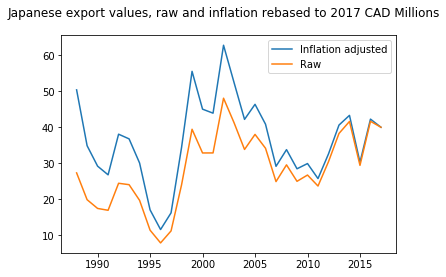

In [20]:
plt.plot(dfInfAdjValues['Japan'],label="Inflation adjusted")
plt.plot(dfValues['Japan'],label="Raw")
plt.legend()
plt.suptitle("Japanese export values, raw and inflation rebased to 2017 CAD Millions", fontsize=12)

Finally, the data can be smoothed through the introduction of a rolling average. Here a window of five years is used.

Text(0.5,0.98,'Export destination trailing 5y average export values, inflation rebased to 2017 CAD Millions')

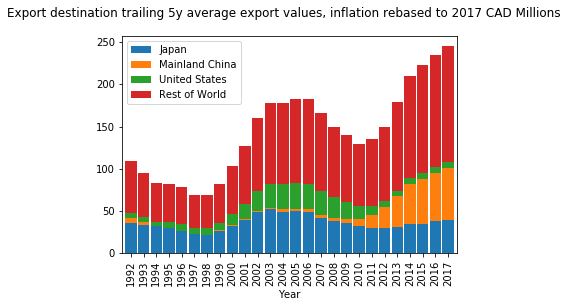

In [21]:
dfInfAdjValues.rolling(window=5).mean().dropna().plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination trailing 5y average export values, inflation rebased to 2017 CAD Millions", fontsize=12)